In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sys.path.append("/home/isidro/Documents/github/SimpleMC/")
from simplemc.plots.plot_Quintom_variables import *
from simplemc.models.QuintomCosmology import QuintomCosmology
from simplemc.models.LCDMCosmology import LCDMCosmology
from simplemc.cosmo.Parameter import Parameter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.utils import to_categorical
# from tensorboard.plugins.hparams import api as hp

# from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import time 

%matplotlib inline

Initalizing nu density look up table... Done


In [2]:
om_ = Parameter("Om", 0.3038, 0.05, (0.1, 0.5), "\Omega_m")
obh2_ = Parameter("Obh2", 0.02234, 0.001, (0.02, 0.025), "\Omega_{b}h^2")
h_ = Parameter("h", 0.6821, 0.05, (0.4, 0.9), "h")
mquin_ = Parameter("mquin", 1.7, 0.2, (0, 4.0), "m_{\phi}")
mphan_ = Parameter("mphan", 0.8, 0.2, (0, 3.0), "m_{\psi}")
iniphi_ = Parameter("iniphi", 0.5, 0.1, (0, 1.5), "\phi_0")
coupling_ = Parameter("beta",  1.0, 0.5, (-10, 10), "\\beta")

In [3]:
minim, maxim = (0.1, 2.5)

T = QuintomCosmology(vary_mquin=True)

ww = []
# dd = []
X = []
Y = []
mquin_data = np.arange(0, 4, 0.5)

for i, val in enumerate(mquin_data):
#     if fname == 'Quintessence':
    mquin_.setValue(val)
    T.updateParams([mquin_])

    T.call_functions()
    zl = np.arange(0.0, 3.5, 0.01)
    wlist = []
    for z in zl:
        X.append([z, val])
        eos = T.w_de(1./(1+z))
        wlist.append(eos)
        Y.append(eos)
    ww.append(wlist)       
#     print(ww[i])

X = np.array(X)
Y = np.array(Y)

In [4]:
np.shape(ww), np.shape(mquin_data), np.shape(zl), np.shape(X), np.shape(Y)

((8, 350), (8,), (350,), (2800, 2), (2800,))

(-1.05, 1.1)

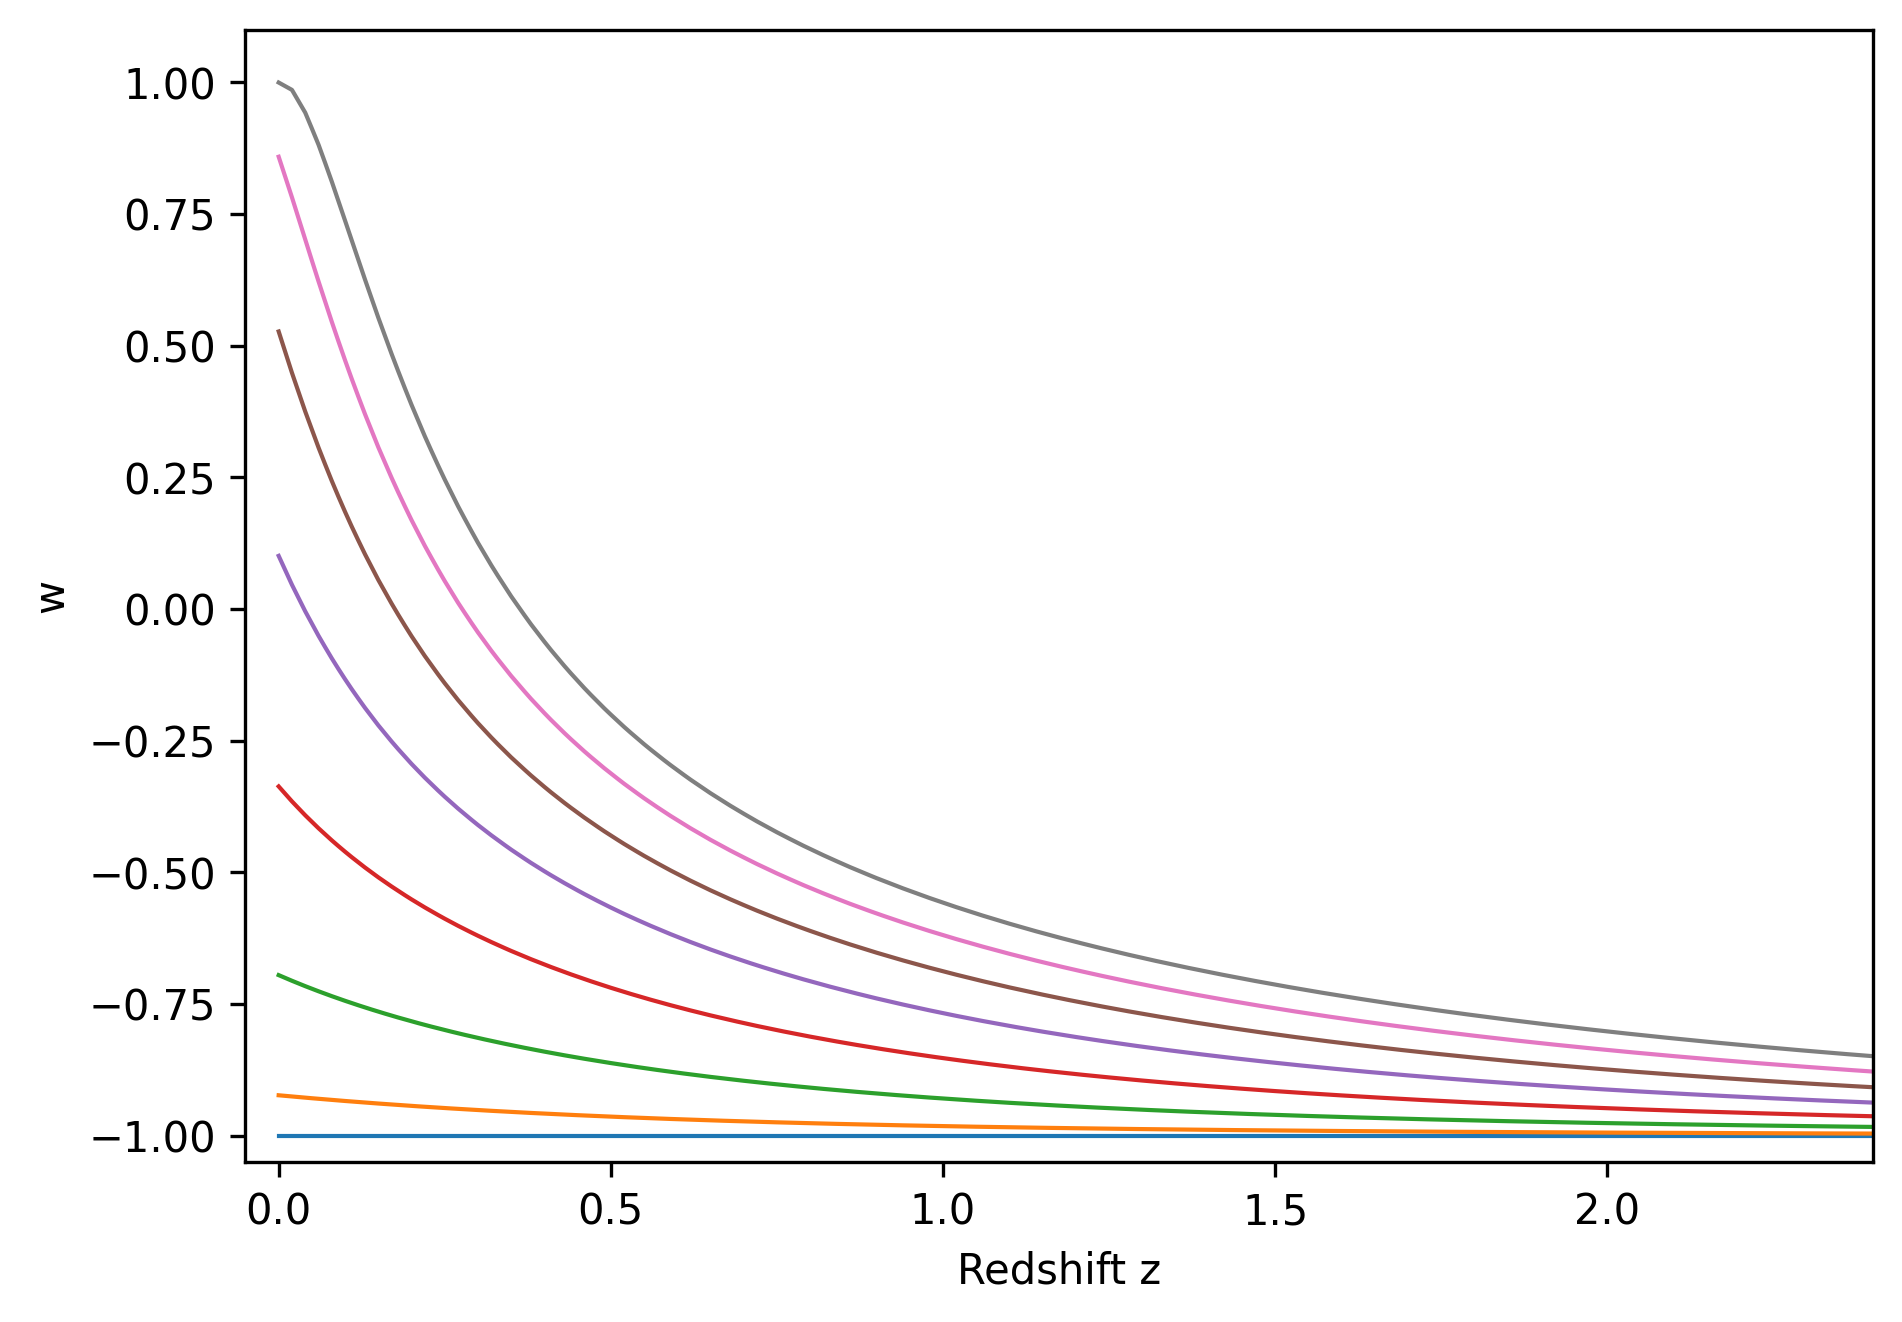

In [5]:
fig = plt.figure(figsize=(7,5), dpi=300)

for line in ww:
    plt.plot(zl, line, alpha=1, lw=1)

plt.xlabel("Redshift z")
plt.ylabel("w")
plt.xlim(-0.05, 2.4)
plt.ylim(-1.05, 1.1)
# plt.hlines(-1, xmin=0, xmax=3.05, colors='red',  linestyles='dashed', label='$w=-1$', lw=3, alpha=1)

In [6]:
epochs=100
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=500,
                                   restore_best_weights=True, verbose=False)
                                   ]

In [7]:
def train_test_model(hparams, X_train, Y_train, X_test, Y_test):    
    
    # Train LSTM model and predict on validation set
    model = tf.keras.Sequential()
    model.add(Dense(int(X_train.shape[1])))
    
    for i in range(hparams['HP_LAYERS']):        
        model.add(Dense(hparams['HP_NUM_UNITS'], activation='relu'))
    model.add(Dense(1, activation='linear'))
     
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['HP_LEARNING'], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(
            optimizer=optimizer,
            loss='mse', 
            metrics=['mean_squared_error'])
    
    # Run with 1 epoch to speed things up for demo purposes

    train = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test),
              callbacks=callbacks, batch_size=hparams['HP_BATCHSIZE'], shuffle=False, verbose=True)

    _, loss = model.evaluate(X_test, Y_test)
    
    return model, loss, train.history

In [8]:
#Separamos los datos en validación y entrenamiento
ntrain = int(0.8 * len(Y))
indx = [ntrain]
shuffle = np.random.permutation(len(X))
X = X[shuffle]
Y = Y[shuffle]
X_train, X_val = np.split(X, indx)
Y_train, Y_val = np.split(Y, indx)
# nval = int(0.5*(len(X_test)))
# indx_val = [nval]
# X_val, X_test = np.split(X_test, indx_val)
# Y_val, Y_test = np.split(Y_test, indx_val)

In [9]:
np.shape(X_train), np.shape(Y_train), np.shape(X_val), np.shape(Y_val)

((2240, 2), (2240,), (560, 2), (560,))

In [10]:
hparams_grid = {'HP_LAYERS': 2, 'HP_NUM_UNITS': 150, 'HP_BATCHSIZE': 16, 'HP_LEARNING':0.001}
model, loss, history = train_test_model(hparams_grid, X_train, Y_train, X_val, Y_val)

Epoch 1/100
140/140 [==============================] - 1s 2ms/step - loss: 0.0644 - mean_squared_error: 0.0644 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 2/100
140/140 [==============================] - 0s 971us/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 3/100
140/140 [==============================] - 0s 996us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 4/100
140/140 [==============================] - 0s 906us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/100
140/140 [==============================] - 0s 987us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 6/100
140/140 [==============================] - 0s 991us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 7/100


Epoch 48/100
140/140 [==============================] - 0s 951us/step - loss: 2.2231e-04 - mean_squared_error: 2.2231e-04 - val_loss: 6.1216e-04 - val_mean_squared_error: 6.1216e-04
Epoch 49/100
140/140 [==============================] - 0s 927us/step - loss: 2.2286e-04 - mean_squared_error: 2.2286e-04 - val_loss: 8.9468e-04 - val_mean_squared_error: 8.9468e-04
Epoch 50/100
140/140 [==============================] - 0s 976us/step - loss: 1.6387e-04 - mean_squared_error: 1.6387e-04 - val_loss: 3.2044e-04 - val_mean_squared_error: 3.2044e-04
Epoch 51/100
140/140 [==============================] - 0s 976us/step - loss: 2.4886e-04 - mean_squared_error: 2.4886e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 52/100
140/140 [==============================] - 0s 973us/step - loss: 1.9069e-04 - mean_squared_error: 1.9069e-04 - val_loss: 4.9817e-04 - val_mean_squared_error: 4.9817e-04
Epoch 53/100
140/140 [==============================] - 0s 921us/step - loss: 1.9337e-04 - mean_sq

140/140 [==============================] - 0s 905us/step - loss: 1.1463e-04 - mean_squared_error: 1.1463e-04 - val_loss: 8.7320e-05 - val_mean_squared_error: 8.7320e-05
Epoch 94/100
140/140 [==============================] - 0s 897us/step - loss: 1.0981e-04 - mean_squared_error: 1.0981e-04 - val_loss: 1.8916e-04 - val_mean_squared_error: 1.8916e-04
Epoch 95/100
140/140 [==============================] - 0s 876us/step - loss: 9.6063e-05 - mean_squared_error: 9.6063e-05 - val_loss: 8.0291e-05 - val_mean_squared_error: 8.0291e-05
Epoch 96/100
140/140 [==============================] - 0s 898us/step - loss: 1.2242e-04 - mean_squared_error: 1.2242e-04 - val_loss: 2.0187e-04 - val_mean_squared_error: 2.0187e-04
Epoch 97/100
140/140 [==============================] - 0s 895us/step - loss: 9.2964e-05 - mean_squared_error: 9.2964e-05 - val_loss: 5.4281e-05 - val_mean_squared_error: 5.4281e-05
Epoch 98/100
140/140 [==============================] - 0s 895us/step - loss: 7.8837e-05 - mean_squared

(-0.001, 0.025)

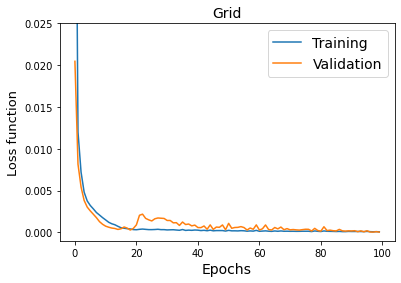

In [11]:
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.ylabel('Loss function', fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.title("Grid", fontsize=14)
plt.ylim(-0.001, 0.025)
# plt.savefig("loss_grid_ecs.png")

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               450       
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 23,257
Trainable params: 23,257
Non-trainable params: 0
_________________________________________________________________


In [13]:
# mphi_test = np.unique(X_test[:, 1])
# ztest = np.unique(X_test[:, 0])
mphi_test = np.arange(0, 4, 0.5)
ztest = np.arange(0.0, 3.5, 0.05)

testset = []
for mphi in mphi_test:
    for z in ztest:
        testset.append([z, mphi])

testset = np.array(testset)
np.shape(testset)

(560, 2)

In [14]:
testset

array([[0.  , 0.  ],
       [0.05, 0.  ],
       [0.1 , 0.  ],
       ...,
       [3.35, 3.5 ],
       [3.4 , 3.5 ],
       [3.45, 3.5 ]])

In [15]:
def eos_fn(params):
#     T = QuintomCosmology(vary_mquin=True)
    z, mphi_val = params
    mquin_.setValue(mphi_val)
    T.updateParams([mquin_])
    T.call_functions()
    
    eos = T.w_de(1./(1+z))
    return eos
    

In [16]:
t1diff = time.time()

T = QuintomCosmology(vary_mquin=True)
ww_diff = list(map(eos_fn, testset))    

tdiff = time.time() - t1diff

In [17]:
t1net = time.time()

ww_net = model.predict(testset)

tnet = time.time() - t1net

In [18]:
tnet, tdiff, np.shape(ww_net), np.shape(ww_diff), np.shape(testset[:,0])

(0.08128213882446289, 39.63537573814392, (560, 1), (560,), (560,))

In [19]:
testset

array([[0.  , 0.  ],
       [0.05, 0.  ],
       [0.1 , 0.  ],
       ...,
       [3.35, 3.5 ],
       [3.4 , 3.5 ],
       [3.45, 3.5 ]])

In [20]:
lines_net = []
lines_diff = []

# testset = []
for i, mphi in enumerate(testset[:,1]):
    if i >0:
        if mphi != testset[i-1, 1]:
            aux1 = []
            aux2 = []
            for j, z in enumerate(ztest):
                aux1.append(ww_diff[i+j])
                aux2.append(ww_net[i+j])
            lines_diff.append(aux1)
            lines_net.append(aux2)

lines_diff = np.array(lines_diff)
lines_net = np.array(lines_net)

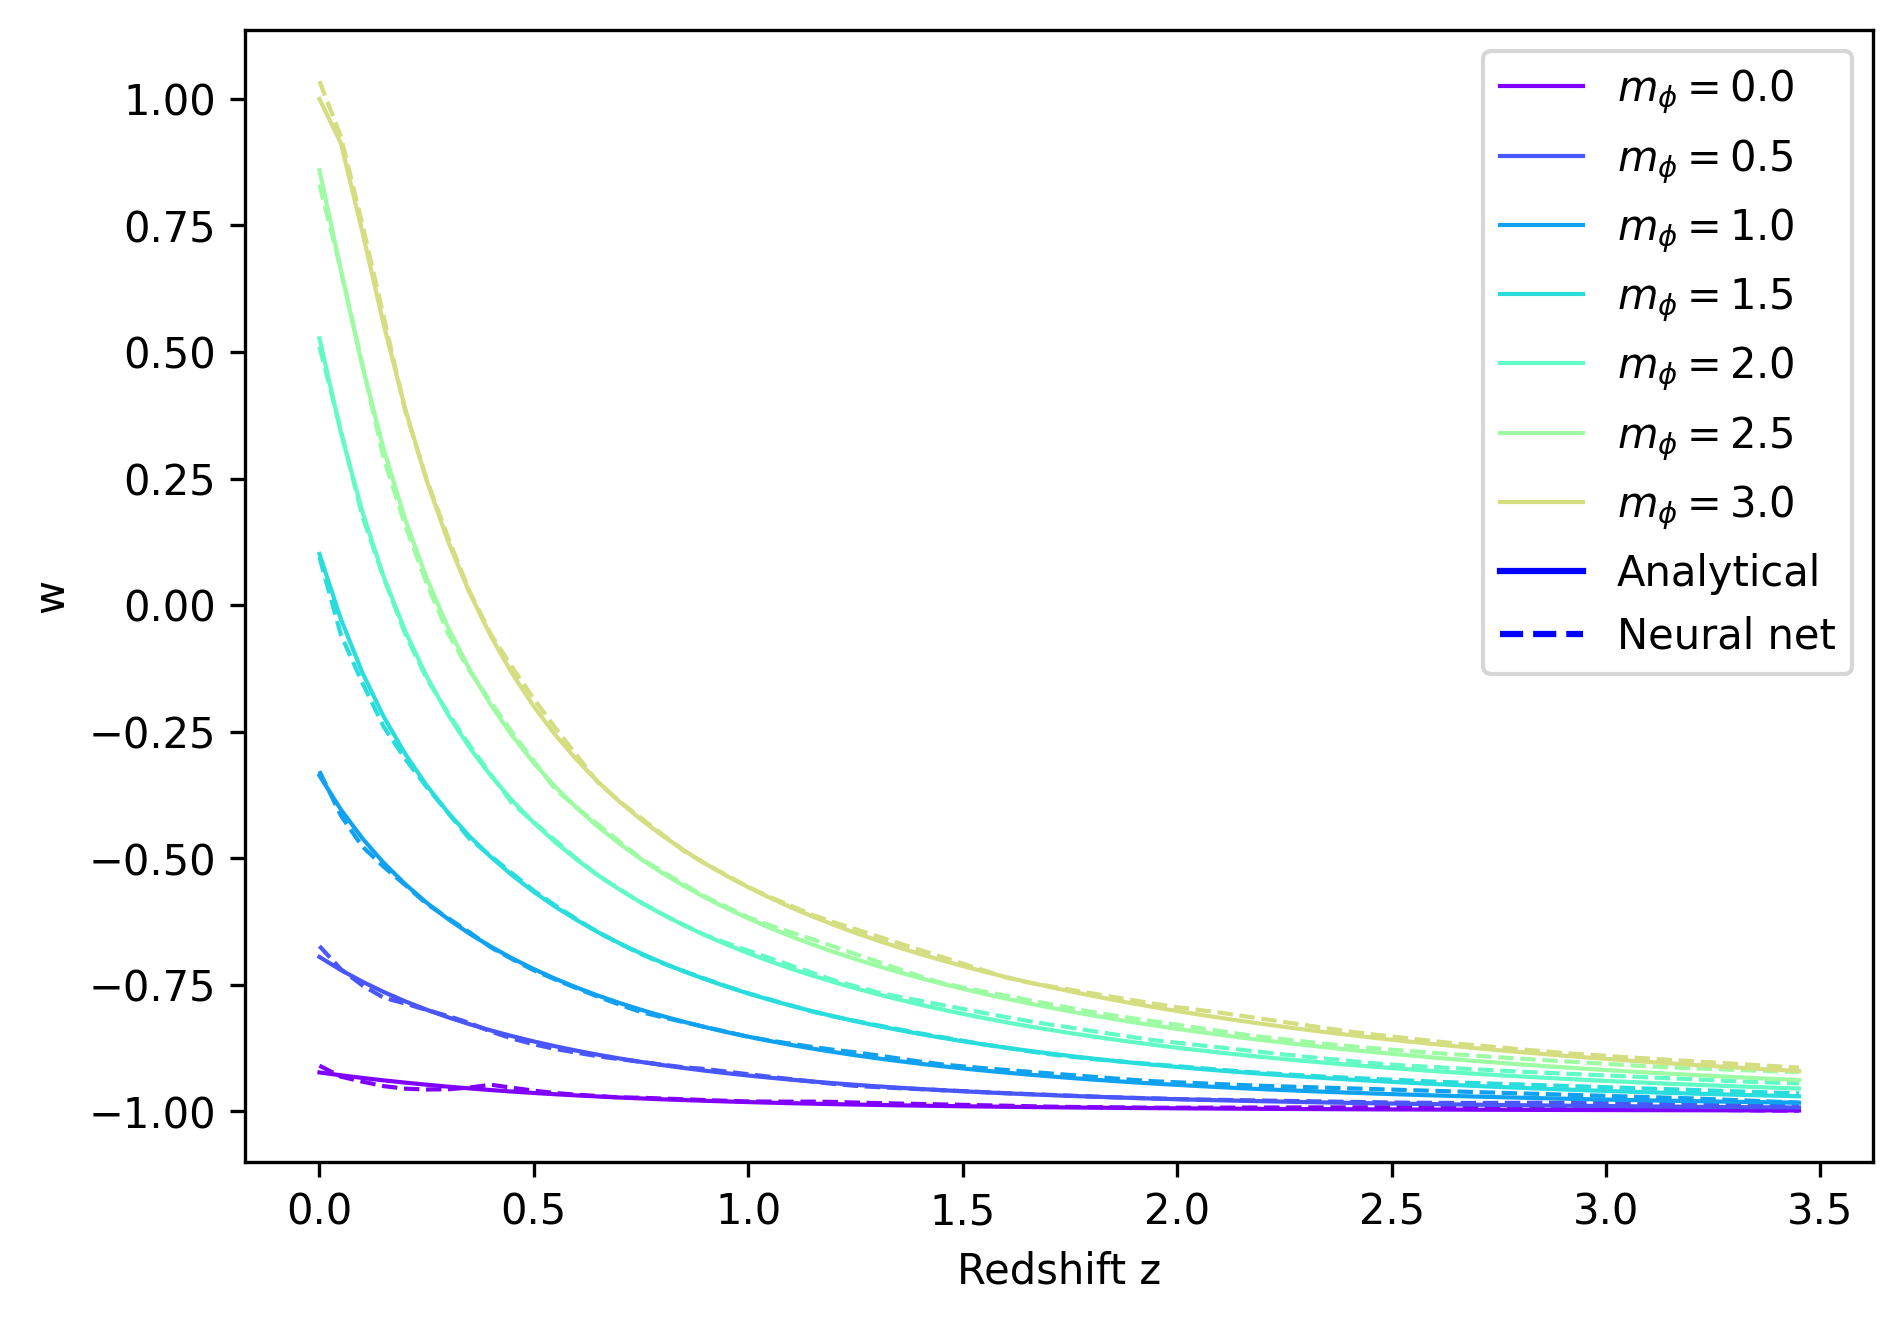

In [21]:
x = np.arange(len(ww_net))
ys = [i+x+(i*x)**2 for i in range(10)]

colors = cm.rainbow(np.linspace(0, 1, len(ys)))

fig = plt.figure(figsize=(7,5), dpi=300)

for i, line in enumerate(lines_diff):
#     if i%10 == 0:
    plt.plot(ztest, lines_diff[i], alpha=1, lw=1, label = "$m_\phi={}$".format(mphi_test[i]), c=colors[i])
    plt.plot(ztest, lines_net[i], alpha=1, lw=1, linestyle='dashed', c=colors[i])

plt.plot(0.1,0.1, label = "Analytical", c='b' )
plt.plot(0.1,0.1, label = "Neural net", linestyle='dashed', c='b')
# plt.plot(np.unique(X_test[:,0]), line, alpha=1, lw=1, linestyle='dashed', c=colors[i])
plt.xlabel("Redshift z")
plt.ylabel("w")
# plt.xlim(-0.05, 2.4)
# plt.ylim(-1.05, 1.1)
# plt.text(1, 0.8, "- Analytical --Neural Net")

plt.legend()
# plt.hlines(-1, xmin=0, xmax=3.05, colors='red',  linestyles='dashed', label='$w=-1$', lw=3, alpha=1)